# Семинар 7
## Решающие деревья и случайный лес

Сегодня на семинаре мы:

* Посмотрим на реализацию дерева решений
* Научимся подбирать параметры модели при помощи методов полного перебора в sklearn
* Познакомимся с реализацией случайного леса
* Научимся подбирать параметры модели для сложных моделей при помощи случайного поиска sklearn

Мы будем решать задачу регрессии на датасете [Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality). Он содершит в себе химические характеристики напитка и оценку, которую выставила ему коммиссия из нескольких сомелье. Процесс оценки вин это долгий, дорогостоящий и часто неточный процесс, ведь в разных коммиссиях будут сидеть разные люди, их может быть разное число и они могут иметь разные предпочтения. 

**Мотивация:** хочется собрать достаточно точные данные оценки вин (достичь этого можно тем, что будет собрана очень большая коммиссия, в которой ответы экспертов усреднятся) и построить алгоритм, который сможет давать рекомендации к оценки вина без необходимости собирать большие коммиссии и сгладит личные предпочтения эксперта.

Датасет имеет 11 параметров вина (результаты обычных физико-химических тестов):

* 1 - Фиксированная кислотность
* 2 - Летучая кислотность
* 3 - Содержание лимонной кислоты
* 4 - Остаточный сахар
* 5 - Содержание хлоридов
* 6 - Содержание свободного диоксида серы
* 7 - Общее содержание диоксида серы
* 8 - Плотность
* 9 - Кислотность pH
* 10 - Содержание сульфатов
* 11 - Градус алкоголя

И столбец оценки вина:
* 12 - Качество (оценка в диапазоне от 0 до 10)

In [1]:
# Импортируем наши стандартные библиотеки
from copy import deepcopy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()

### Подготовка данных и EDA

In [2]:
# Мы будем использовать датасет для красных вин, которые лежат по ссылке
# https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
# Считаем данные по ссылки при помощи метода read_csv библиотеки pandas и дополнительно укажем в качестве разделения в данных (sep) символ ";"

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")

In [3]:
# Посмотрим на наши данные

df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [4]:
# Проверим есть ли в наших данных пропуски и заодно посомтрим на типы данных при помощи метода info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
# Видим, что у нас уже нет пропусков и все данные являются числовыми, что сильно упрощает работу
# Поэтому перед тем как переходить к обучению модели, посмотрим, еще, на статистики каждого признака 
# Воспользовавшись методом describe

df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
# Разделим данные на признаки и таргет

X = df.drop(columns = ["quality"])
y = df["quality"]

Уникальные оценки: [5 6 7 4 8 3]



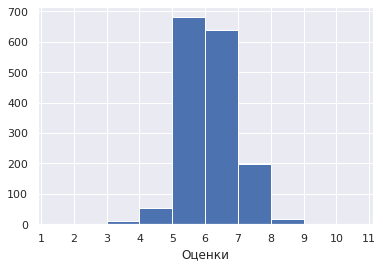

In [6]:
# Посмотрим внимательно на наш таргет, посмотрев на уникальные значения (unique) и построив гистограмму (hist)
# NOTE в качестве бинов передайте [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

print(f"Уникальные оценки: {y.unique()}\n")
y.hist(bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

plt.xlabel("Оценки")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
plt.xlim(0.9, 11.1)
plt.show()

Какие можно сделать выводы?

In [8]:
# Разобьем данные на обучение и тест при помощи функции train_test_split
# Несмотря на то, что у нас задача регрессии -- воспользуемся стратификацией по таргету,
# Поскольку его природа это позволяет

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 13)

In [9]:
# Посмотрим на размеры получившегося обучающего датасета
X_train.shape

(1199, 11)

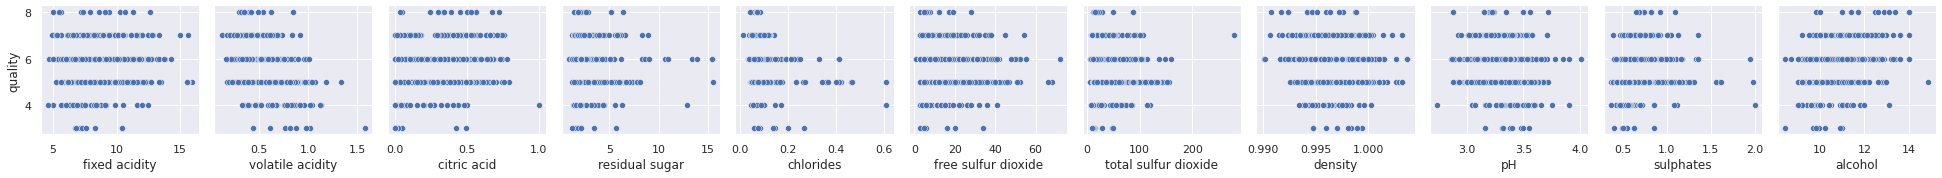

In [10]:
# Построим график зависимости оценки вина от каждого из признаков на обучающей части

X_train_plot = deepcopy(X_train)
X_train_plot["quality"] = y_train

sns.pairplot(
    X_train_plot,
    x_vars=X_train.columns,
    y_vars=["quality"],
)

plt.show()

Какие инсайды мы можем сейчас выделить?

In [12]:
# Прежде чем переходить к этапу построения модели необходимо понять какими метриками мы будем оценивать работу нашего алгоритма
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error

### Решение задачи при помощи дерева принятия решения

[Документация алгоритма](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

In [13]:
# Импортируем класс DecisionTreeRegressor из модуля tree библиотеки sklear
from sklearn.tree import DecisionTreeRegressor

#### Для начала построим бейзлайн модель дерева решений

In [14]:
# Создадим объект класса DecisionTreeRegressor с параметрами по умолчанию
DTR = DecisionTreeRegressor()

# Обучим его на обучающей части датасета при помощи метода fit
DTR.fit(X_train, y_train)

DecisionTreeRegressor()

In [15]:
# Получим предсказание нашего дерева при помощи метода predict на обучающем и тестовом датасете
y_DTR_train_predict = DTR.predict(X_train)
y_DTR_test_predict = DTR.predict(X_test)

In [ ]:
# Посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма

print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_DTR_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_DTR_train_predict)}")
print(f"MSE:       {mean_squared_error(y_train, y_DTR_train_predict)}")
print("TEST")
print(f"MAX ERROR: {max_error(y_test, y_DTR_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_DTR_test_predict)}")
print(f"MSE:       {mean_squared_error(y_test, y_DTR_test_predict)}")

TRAIN
MAX ERROR: 0.0
MAE:       0.0
MSE:       0.0
TEST
MAX ERROR: 3.0
MAE:       0.4575
MSE:       0.6025


Мы видим, что поскольку мы не ограничили грубину дерева, алгоритм переобучился на обучающей выборке.

Давайте повторим тот же пайплайн, но ограничив глубину дерева.

In [16]:
# Создадим объект класса DecisionTreeRegressor с max_depth равным числу (например 5)
DTR = DecisionTreeRegressor(max_depth = 5)

# Обучим его на обучающей части датасета при помощи метода fit
DTR.fit(X_train, y_train)

# Получим предсказание нашего дерева при помощи метода predict на обучающем и тестовом датасете
y_DTR_train_predict = DTR.predict(X_train)
y_DTR_test_predict = DTR.predict(X_test)

# Посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма
print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_DTR_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_DTR_train_predict)}")
print("TEST")
print(f"MAX ERROR: {max_error(y_test, y_DTR_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_DTR_test_predict)}")

TRAIN
MAX ERROR: 2.2442396313364057
MAE:       0.4496686336604965
TEST
MAX ERROR: 3.0
MAE:       0.5159367042205742


Уже лучше, но получается, что нам нужно подобрать подходящую максимальную глубину (`max_depth`). Однако у дерева есть еще один параметр, который стоит настраивать -- `min_samples_leaf`. Этот параметр также позволяет бороться с переобучением и не такой радикальный как `max_depth`.


Получается, что у нас есть два параметра, которые мы хотели бы настраивать и мы могли бы просто запустить два вложенных цикла, чтобы перебрать все возможные варианты и выбрать наилучший, но дело в том, что циклы в python по умолчанию не выполняются параллельно. Кроме того вам бы пришлось написать дополнительные функции для отслеживания качества алгоритма. 

К счастью, в `sklearn` уже есть реализованный функционал для этого!

#### Подбор параметров при помощи `GridSearchCV`

In [18]:
# Импортируем GridSearchCV из модуля model_selection библиотеки sklearn
from sklearn.model_selection import GridSearchCV

`GridSearchCV` -- очень простая сущность. Он позволяет быстро перебирать все возможные комбинации заданных параметров модели. Он умеет работать в несколько потоков, имеет функционал подсчета метрик, кросс-валидации и много других бонусов, которые позволяют вам быстро и без изобретания велосипедов подобрать параметры вашей модели.

[Подробнее о GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

In [19]:
# Воспользуем функцией GridSearchCV
# В качестве определения "лучшей" модели выберем mean_absolute_error

grid = GridSearchCV(
            DecisionTreeRegressor(),                # Алгоритм, в котором будем подбирать параметры
            param_grid = {                          # Сетка параметров в виде словаря
                'max_depth': range(1, 8),
                'min_samples_leaf': range(1, 8),
            },
            scoring = 'neg_mean_absolute_error',    # Какие метрики будут считаться (Почему "neg_..."?)
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid.fit(X_train, y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 8),
                         'min_samples_leaf': range(1, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=5)

In [20]:
# Выведем набор лучших параметров (они хранятся в best_params_) и лучшую метрику

print(f"Лучшая метрика:   {grid.best_score_}")
print(f"Лучшие параметры: {grid.best_params_}")

Лучшая метрика:   -0.5160195633252206
Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 4}


In [21]:
# Получим предсказание нашего лучшего дерева (хранится в best_estimator_) при помощи метода predict на обучающем и тестовом датасете
y_GS_train_predict = grid.best_estimator_.predict(X_train)
y_GS_test_predict = grid.best_estimator_.predict(X_test)

# Посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма
print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_GS_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_GS_train_predict)}")
print("TEST")
print(f"MAX ERROR: {max_error(y_test, y_GS_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_GS_test_predict)}")

TRAIN
MAX ERROR: 2.164835164835165
MAE:       0.4570603831624545
TEST
MAX ERROR: 2.7142857142857144
MAE:       0.5037168637561387


Видим, что метрики действительно улучшились как на обучающем, так и на валидационном датасете.

#### Отрисовка работы лучшего решающего дерева

Модуль tree библиотеки sklearn имеет функционал для отрисовки дерева решений. Это часто бывает удобно если хочется понять почему алгоритм принял то или иное решение.

In [22]:
# Импортируем функцию plot_tree из модуля tree библиотеки sklearn
from sklearn.tree import plot_tree

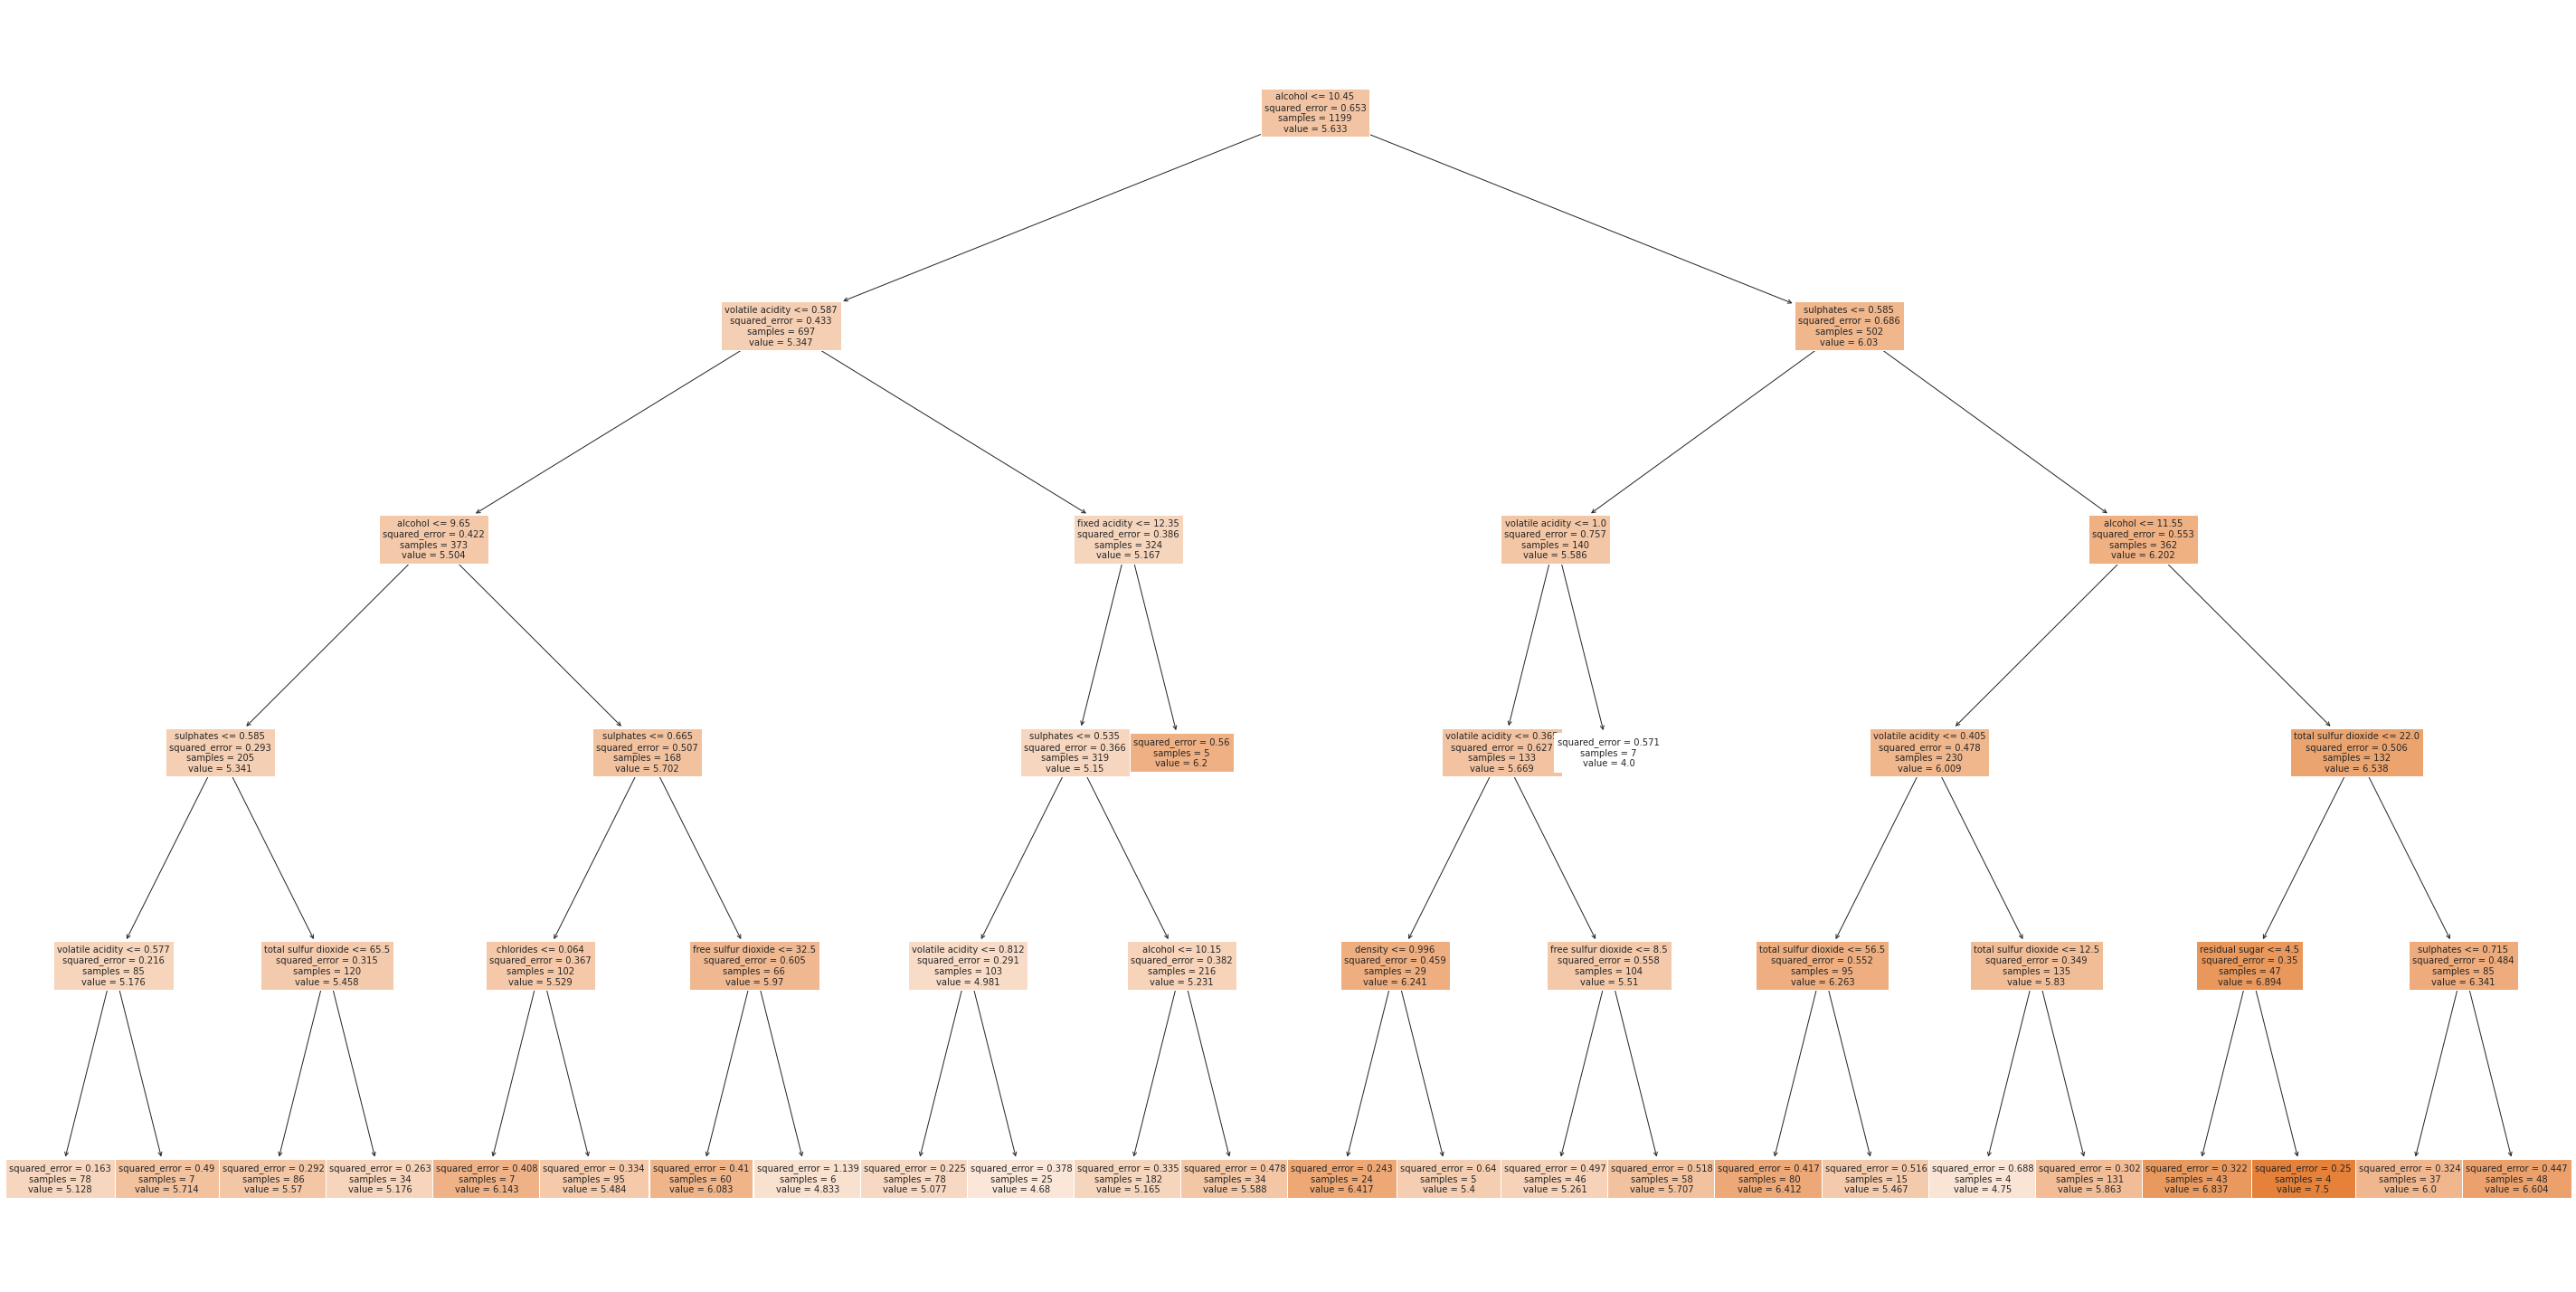

In [23]:
# Нарисуем наше лучшее дерево из сетки

fig = plt.figure(figsize=(40, 20))

_ = plot_tree(
        grid.best_estimator_, 
        feature_names = X_train.columns,  
        class_names = y_train.name,
        filled = True,
        fontsize = 10
    )
plt.tight_layout()

К сожалению из-за того, что у нас большая глубина, видно не все, но это можно настроить поигравшись с размером картинки шрифтом.

*Какие выводы мы можем сделать глядя на наше дерево?*

### Решение задачи при помощи случайного леса

[Документация алгоритма](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

In [24]:
# Импортируем класс RandomForestRegressor из модуля ensemble библиотеки sklear
from sklearn.ensemble import RandomForestRegressor

#### Построим бейзлайн модельи случайного леса

In [25]:
# Создадим объект класса RandomForestRegressor с параметрами по умолчанию
RFR = RandomForestRegressor()

# Обучим его на обучающей части датасета при помощи метода fit
RFR.fit(X_train, y_train)

RandomForestRegressor()

In [26]:
# Получим предсказание нашего случайного леса при помощи метода predict на обучающем и тестовом датасете
y_RFR_train_predict = RFR.predict(X_train)
y_RFR_test_predict = RFR.predict(X_test)

In [27]:
# Посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма

print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_RFR_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_RFR_train_predict)}")
print("TEST")
print(f"MAX ERROR: {max_error(y_test, y_RFR_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_RFR_test_predict)}")

TRAIN
MAX ERROR: 1.2699999999999996
MAE:       0.1625688073394495
TEST
MAX ERROR: 2.4800000000000004
MAE:       0.39025


Видим, что результаты на голову выше обычного дерева решений, но также мы видим, что у нас есть переобучение.

#### Подбор параметров при помощи `RandomizedSearchCV`

Вспомним какие параметры есть у случайного леса и какие нужно оптимизировать.

У нас есть:

* Число деревьев в лесе (`n_estimators`) -- этот параметр просто нужно выбрать достаточно большим
* Максимальное число признаков у дерева (`max_features`) -- это самый важный параметр.
* Максимальная глубина деревьев (`max_depth`) -- желательно не ограничивать, но это очень ресурсоемко, поэтому нужн оподобрать достаточно глубкие, но все же органиченные.
* Минимальное число объектов в вершине для расщепления (`min_samples_split`) -- подбирается исходя из данных.

То есть у нас есть сложный алгоритм (в `n_estimators` раз сложнее решающего дерева) и 3 параметра для подбора. Даже с быстрым `GridSearchCV` это будет долго. Поэтому мы воспользуемся его братом-близнецом `RandomizedSearchCV`, который перебирает не все возможные комбинации, а заданное число случайных.

[Подробнее о RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)

In [28]:
# Импортируем GridSearchCV из модуля model_selection библиотеки sklearn
from sklearn.model_selection import RandomizedSearchCV

In [29]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем mean_absolute_error

grid = RandomizedSearchCV(
            RandomForestRegressor(),                # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(6, 50),
                'min_samples_split': range(3, 5),
                'max_features': range(2, 11)
            },
            scoring = 'neg_mean_absolute_error',    # Какие метрики будут считаться (Почему "neg_..."?)
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=16,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=16,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(6, 50),
                                        'max_features': range(2, 11),
                                        'min_samples_split': range(3, 5)},
                   return_train_score=True, scoring='neg_mean_absolute_error',
                   verbose=5)

In [30]:
# Выведем набор лучших параметров (они хранятся в best_params_) и лучшую метрику

print(f"Лучшая метрика:   {grid.best_score_}")
print(f"Лучшие параметры: {grid.best_params_}")

Лучшая метрика:   -0.4551334259756534
Лучшие параметры: {'min_samples_split': 4, 'max_features': 8, 'max_depth': 46}


Очевидно, что `max_depth` выбрана максимальной, ведь так и стоится случайный лес:)
Мы в этом еще раз убедились!

In [31]:
# Получим предсказание нашего лучшего дерева (хранится в best_estimator_) при помощи метода predict на обучающем и тестовом датасете
y_GS_train_predict = grid.best_estimator_.predict(X_train)
y_GS_test_predict = grid.best_estimator_.predict(X_test)

# Посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма
print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_GS_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_GS_train_predict)}")
print("TEST")
print(f"MAX ERROR: {max_error(y_test, y_GS_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_GS_test_predict)}")

TRAIN
MAX ERROR: 1.1834999999999996
MAE:       0.17976795628150924
TEST
MAX ERROR: 2.4721190476190484
MAE:       0.3975880185786435


Видим, что ошибка немного уменьшилась (на самом деле параметры по умолчанию достаточно хороши), однако мы не смогли избавиться от переобучения. Что мы можем сделать с этим? Какие параметры нужно настроить?

Можем проверить ваши гипотезы ниже:)